# Signal-to-noise ratio as forecast proficiency

In [64]:
import numpy as np
import simulations
import matplotlib.pyplot as plt
from snr import *

## Perfect Model Scenario: The model world

/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/models.py:157: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


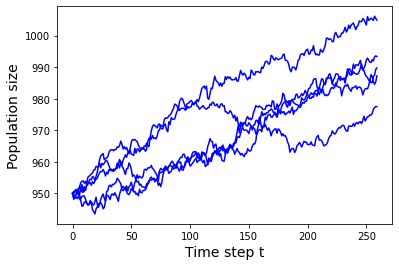

In [65]:
# create simulator object
sims = simulations.Simulator()
# Set hyperparameters. We'll simulate on a weekly resolution. Years is changed to weeks.
sims.hyper_parameters(simulated_years=5,
                           ensemble_size=5,
                           initial_size=950)
sims.simulation_parameters(regime="non-chaotic", behaviour="stochastic")
sims.environment('non-exogeneous', trend=False)
sims.model_type("single-species")
x_mod = sims.simulate()

We create the perfect model setting by treating one trajectory from the simulated ensemble as observation.
We bootstrap this procedure to propagate uncertainty in initial conditions and thereby get a distribution of the SNR. Here, we use the squared-error-based SNR (Czanner et al. 2015, PNAS). This is calculcated based on the expected prediction error (HOWEVER: only defined on linear models which this is clearly not!)

$SNR = \frac{SS(y,\overline{y}) - SS(y,\hat{y})}{SS(y,\hat{y})}$

The signal is the reduction in prediction error by using the model instead of simply using the mean.

/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/snr.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return signal/noise
/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_73621/1428246505.py:15: RuntimeWarning: invalid value encountered in log
  ax1.plot(np.log(bs_modelworld), color="blue", alpha=0.3)
/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_73621/1428246505.py:18: RuntimeWarning: invalid value encountered in log10
  ax2.plot(np.transpose(10*np.log10(bs_modelworld)), color="blue", alpha = 0.3)


Text(0, 0.5, 'SS-SNR [decibel]')

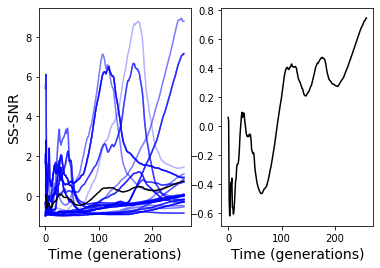

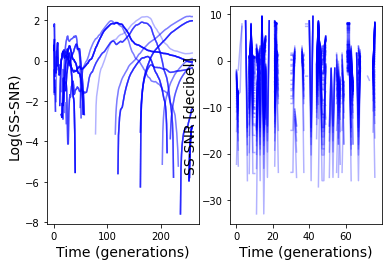

In [66]:
bs_modelworld = bs_sampling(x_mod, x_mod, 'ss-snr')
bs_modelworld = bs_modelworld[:,~np.isinf(bs_modelworld).any(0)]

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(bs_modelworld, color="blue", alpha=0.3)
ax1.plot(np.mean(bs_modelworld, axis=1), color="black")
ax1.set_xlabel('Time (generations)', size=14)
ax1.set_ylabel('SS-SNR', size=14)
ax2.plot(np.mean(bs_modelworld, axis=1), color="black")
ax2.set_xlabel('Time (generations)', size=14)
#plt.plot(bs_arr_modelworld)


fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(np.log(bs_modelworld), color="blue", alpha=0.3)
ax1.set_xlabel('Time (generations)', size=14)
ax1.set_ylabel('Log(SS-SNR)', size=14)
ax2.plot(np.transpose(10*np.log10(bs_modelworld)), color="blue", alpha = 0.3)
ax2.set_xlabel('Time (generations)', size=14)
ax2.set_ylabel('SS-SNR [decibel]', size=14)

Here, values for the SNR can get incredibly large at the beginning. This is due to the little uncertainty in trajectories: they are basically the same until time step 15.

Let's try it differently and simpler. We take the mean of the forecast distribution as signal and the dispersion as noise. To get a distribution, we evolve the ensemble of trajectories (Timothy delSole, 2004). As such, the signal is the expected value, $E[X]$ and the noise the variance, $Var[X] = E[X^2] - E[X]^2$.

With this, we calculate the raw SNR as:

$SNR = \frac{E[X]}{(E[X^2] - E[X]^2)^2}$


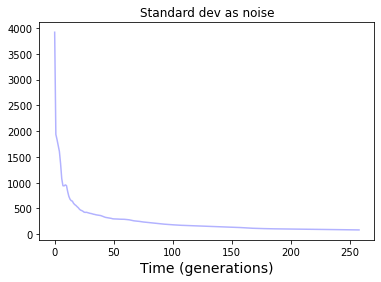

In [67]:
snr_list_std = []
for i in range(sims.hp['iterations']-1):
    snr_list_std.append(raw_SNR(x_mod[:,:i+2], var=False))

fig = plt.figure()
ax = fig.add_subplot()
ax.title.set_text('Variance as noise')
ax.plot(np.mean(np.array(snr_list_std), axis=1), color="blue", alpha = 0.3)
#ax.plot(np.array(snr_list_std), color="blue", alpha = 0.3)
ax.set_xlabel('Time (generations)', size=14)
ax.title.set_text('Standard dev as noise')

This is just the ratio of the ensemble mean against the ensemble variance and works in the perfect model scenario. However, we need an SNR-measure that allows us to consider a reference: The Signal with reference to something like the long-term mean of our observations (if simulated simulated or simulated real).
Doing so, we use the contrast-to-noise ratio (CNR) that is calculated as:

$CNR = \frac{E[\hat{X} - \overline{X}]}{(E[X^2] - E[X]^2)^2}$

[-0.9291888  -0.24342473 -0.04864217 -0.08332493  0.00617011  0.14650268
  0.23312222  0.1009294   0.08293633  0.11354085  0.13856011  0.14592735
  0.16705456  0.19638135  0.2462464   0.28640634  0.30341586  0.31480867
  0.32790772  0.34365209  0.38295769  0.40888786  0.47490158  0.53086344
  0.55511124  0.54527505  0.57172978  0.61311565  0.61781058  0.61952603
  0.63255408  0.65759226  0.65109897  0.63964916  0.6435203   0.62517134
  0.63177097  0.65371767  0.68081433  0.68703509  0.66260896  0.61220655
  0.55947004  0.53425719  0.52552539  0.49579884  0.49767845  0.48196705
  0.46536148  0.43662682  0.43354697  0.44254697  0.45079835  0.45999964
  0.46609303  0.47606862  0.47383528  0.47822407  0.48514125  0.48681287
  0.48774639  0.48738391  0.48281263  0.47155923  0.45746881  0.4336392
  0.41252518  0.40524103  0.39882346  0.39962979  0.39664754  0.3920454
  0.38606763  0.37435216  0.36779349  0.36082503  0.35550949  0.34853416
  0.34299488  0.33670907  0.33436767  0.3373167   0.3

/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_73621/166876491.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


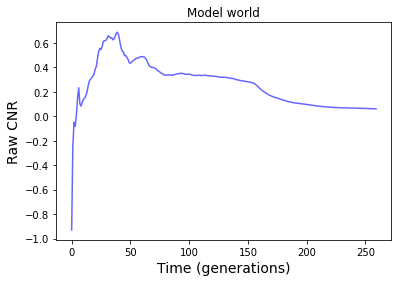

In [68]:
bs_modelworld = bs_sampling(x_mod, x_mod, 'cnr')
bs_modelworld = bs_modelworld[:,~np.isinf(bs_modelworld).any(0)]

bs_modelworld = bs_modelworld[:,~np.isinf(bs_modelworld).any(0)]
log = False
if log:
    bs_modelworld = np.log(bs_modelworld)

q1, q2 = np.quantile(bs_modelworld, (0.1, 0.90), axis=1)

fig = plt.figure()
ax = fig.add_subplot()
#ax.fill_between(np.arange(sims.hp['iterations']), q1, q2, color="lightgrey", alpha=0.5)
plt.plot(np.mean(bs_modelworld, axis=1), color="blue", alpha = 0.6)
#plt.plot(bs_modelworld, color="blue", alpha = 0.6)
ax.set_xlabel('Time (generations)', size=14)
ax.set_ylabel('Raw CNR', size=14)
ax.title.set_text('Model world')
fig.show()

print(np.mean(bs_modelworld, axis=1))

## Imperfect Model Scenario: The data world

Now lets change world: From the Perfect Model Scenario, we move to the real world scenario. Doing so, we will use the real world model that is slightly more complex than the simple one. It contains an interaction with another species, that we will not consider (as if we weren't aware)


/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/models.py:157: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


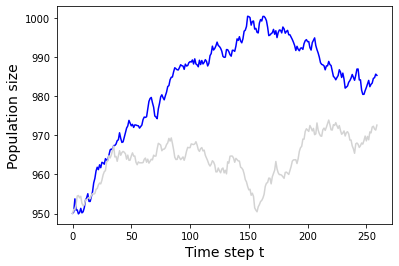

In [69]:
# create simulator object
sims = simulations.Simulator()
# Set hyperparameters. We'll simulate on a weekly resolution. Years is changed to weeks.
sims.hyper_parameters(simulated_years=5,
                           ensemble_size=1,
                           initial_size=(950, 950)) # here we have to give init for both populations
sims.simulation_parameters(regime="non-chaotic", behaviour="stochastic")
sims.environment('non-exogeneous', trend=False)
sims.model_type("multi-species")
x_true = sims.simulate()

/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_73621/865356280.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


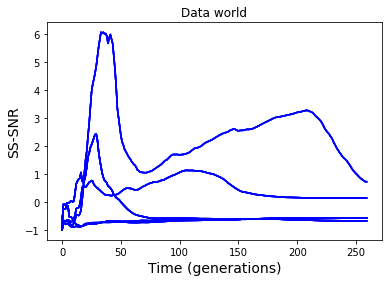

In [70]:
# We only use the data from one species, this is our real world data.
x_true = x_true[:,:,0]#.reshape(sims.hp['iterations'])
bs_dataworld = bs_sampling(x_true, x_mod, 'ss-snr')

bs_dataworld = bs_dataworld[:,~np.isinf(bs_dataworld).any(0)]
q1, q2 = np.quantile(bs_dataworld, (0.1, 0.90), axis=1)

fig = plt.figure()
ax = fig.add_subplot()
#ax.fill_between(np.arange(sims.hp['iterations']), q1, q2, color="lightgrey", alpha=0.3)
plt.plot(bs_dataworld, color="blue", alpha = 0.3)
ax.set_xlabel('Time (generations)', size=14)
ax.set_ylabel('SS-SNR', size=14)
ax.title.set_text('Data world')
fig.show()

The task here is difficult through the chaotic behaviour of the model. In the perfect model scenario, what is it that we use as the variance of the noise?! If I use initial uncertainty, I will get a huge amplitude in the resulting SNR.

Now the predictability limit as the limit where the SNR falls below some threshold. Intuitively, this threshold is one: When Signal becomes weaker than the noise. What we see with this simple approach to setting a threshold is: Both times an EFH of zero: First, because the SNR never even comes close to zero, second because it is constantly negative.
Here it makes a big difference if we use the mean or the median!

/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_73621/1075670974.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(5, 260)


/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_73621/1075670974.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


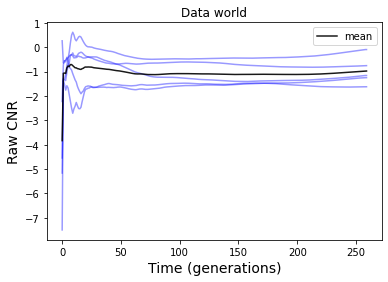

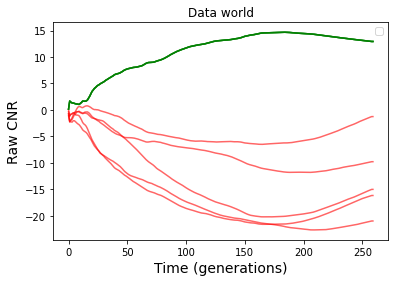

In [71]:
from snr import raw_CNR

cnr_dataworld = []
s_dataworld = []
n_dataworld = []
for i in range(x_mod.shape[0]):
    x_pred = x_mod[i].flatten()
    cnr = []
    signal = []
    noise = []
    for j in range(x_mod.shape[1]):
        r, s, n = raw_CNR(x_true.flatten()[:j + 2], x_pred[:j + 2], squared=False)
        cnr.append(r)
        signal.append(s)
        noise.append(n)
    cnr_dataworld.append(cnr)
    s_dataworld.append(signal)
    n_dataworld.append(noise)

print(np.array(cnr_dataworld).shape)
#bs_dataworld = bs_dataworld[:,~np.isinf(bs_dataworld).any(0)]
log = False
if log:
    cnr_dataworld = np.log(cnr_dataworld)

q1, q2 = np.quantile(bs_dataworld, (0.1, 0.90), axis=1)

fig = plt.figure()
ax = fig.add_subplot()
#ax.fill_between(np.arange(sims.hp['iterations']), q1, q2, color="lightgrey", alpha=0.5)
plt.plot(np.transpose(cnr_dataworld), color="blue", alpha = 0.4)
plt.plot(np.mean(np.transpose(cnr_dataworld), axis=1), color="black", alpha = 0.9, label = "mean")
ax.set_xlabel('Time (generations)', size=14)
ax.set_ylabel('Raw CNR', size=14)
ax.title.set_text('Data world')
ax.legend()
fig.show()

fig = plt.figure()
ax = fig.add_subplot()
#ax.fill_between(np.arange(sims.hp['iterations']), q1, q2, color="lightgrey", alpha=0.5)
plt.plot(np.transpose(s_dataworld), color="red", alpha = 0.6)
plt.plot(np.transpose(n_dataworld), color="green", alpha = 0.6)
ax.set_xlabel('Time (generations)', size=14)
ax.set_ylabel('Raw CNR', size=14)
ax.title.set_text('Data world')
ax.legend()
fig.show()

# Determine an EFH

In [72]:

print('Minimum CNR perfect model world: ', bs_modelworld.min(axis=1))
print('Minimum CNR data world: ', cnr_dataworld.min(axis=1))

CNR_model = np.mean(bs_modelworld, axis=1)
CNR_data = np.mean(cnr_dataworld, axis=1)
threshold = 1
pred_skill_model = np.argmax(CNR_model < threshold)
pred_skill_data = np.argmax(CNR_data < threshold)
print('Forecast horizon in the perfect model scenario: ', pred_skill_model)
print('Forecast horizon in the data world scenario: ', pred_skill_data)

Minimum CNR perfect model world:  [-9.75440492 -3.81763146 -3.96531265 -4.7016632  -3.66258497 -2.74766323
 -2.63309537 -3.25010362 -3.77271615 -4.11108503 -4.30273898 -3.57652727
 -3.19811878 -3.02660151 -2.92155448 -2.97898838 -2.92017808 -2.99158626
 -2.94835616 -2.67941466 -2.42983813 -2.31658677 -2.29423667 -2.24626487
 -2.20874492 -2.14919859 -2.17996195 -2.22080309 -2.20117128 -2.20032447
 -2.19246148 -2.20601344 -2.19643844 -2.19984731 -2.19803202 -2.19515863
 -2.19706912 -2.2069788  -2.20089374 -2.1493742  -2.12768757 -2.11136416
 -2.07199384 -2.03054165 -1.98527974 -1.95465177 -1.96839552 -1.97957433
 -1.98690526 -1.9929307  -2.00485629 -2.0228469  -2.03569396 -2.05554821
 -2.07128083 -2.08986385 -2.10341578 -2.11914136 -2.13343393 -2.14639043
 -2.15621357 -2.16635093 -2.16957202 -2.17353285 -2.17751434 -2.16481001
 -2.15522678 -2.14220089 -2.13600767 -2.1321799  -2.12918361 -2.12176649
 -2.10418207 -2.08414126 -2.05729101 -2.03510828 -2.01618132 -1.98500275
 -1.95309861 -1.9

AttributeError: 'list' object has no attribute 'min'

# Relating Model and Data SNR distributions

We now simulate a stable state system as real data, that we try to approximate with the model.

In [ ]:
# create simulator object
sims = simulations.Simulator()
# Set hyperparameters. We'll simulate on a weekly resolution. Years is changed to weeks.
sims.hyper_parameters(simulated_years=100,
                           ensemble_size=1,
                           initial_size=(1000, 1000)) # here we have to give init for both populations
sims.simulation_parameters(regime="non-chaotic", behaviour="stochastic")
sims.environment('non-exogeneous', trend=False)
sims.model_type("multi-species")
x_true = sims.simulate()

x1 = x_true[:,:,0]
x2 = x_true[:,:,1]
print(x1.shape)
print(x2.shape)

We can plot this dynamics in phase space: how develops one population alongside the other.

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.transpose(x1), np.transpose(x2), color="blue", alpha = 0.6)
ax.set_xlabel('x1', size=14)
ax.set_ylabel('x2', size=14)
ax.title.set_text('')
fig.show()

In [ ]:
snr_data = []
snr_model = []
for i in range(sims.hp['iterations']-1):
    snr_data.append(raw_SNR(x1[:,:i+2], var=False))
    snr_model.append(raw_SNR(x_mod[:,:i+2], var=False))
print(np.array(snr_data).shape)
print(np.array(snr_model).shape)
print('Minimum SNR modelled trajectories:', np.array(snr_model).min(axis=0))
print('Minimum SNR data trajectories:',np.array(snr_data).min(axis=0))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.log(np.array(snr_model)), color="blue", alpha = 0.6)
ax.plot(np.log(np.array(snr_data)), color="red", alpha = 0.6, label = "data")
ax.set_xlabel('Time (generations)', size=14)
ax.set_ylabel('Log(SNR)', size=14)
ax.legend()

In [ ]:
mod = []
for i in range(np.array(snr_model).shape[1]):
    mod.append(np.array(snr_model)[:,i]/(np.max(np.array(snr_model)[:,i])- np.min(np.array(snr_model)[:,i])))
dat = np.array(snr_data)/(np.max(np.array(snr_data))- np.min(np.array(snr_data)))

fig = plt.figure()
ax = fig.add_subplot()
for i in range(np.array(snr_model).shape[1]):
    ax.plot(mod[i],dat, color="blue", alpha = 0.6)
ax.set_xlabel('Standardized SNR data', size=14)
ax.set_ylabel('Standardized SNR model', size=14)
ax.title.set_text('Signal noise ratio in phase space')

# Relate the SNR to the long-time average